# Data Windowing and implementing models

### Table of Contents
1. [Splitting and Normalizing data](#1-Loading-Splitting-and-Normalizing)
2. [Data windowing](#2-Data-windowing)
3. [Single step models](#3-Single-Step-Models)
4. [Multi step models](#4-Multi-Step-Models)

# 1-Loading-Splitting-and-Normalizing

### Loading

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Loading in data that we processed
df = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv',index_col=0, parse_dates=[0])

/Users/evansweeney/Desktop/492_project_local/cmse492_project/tornado/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Splitting

Total samples: 52608
Training samples: 36825
Validation samples: 10522
Test samples: 5261
Number of features: 17


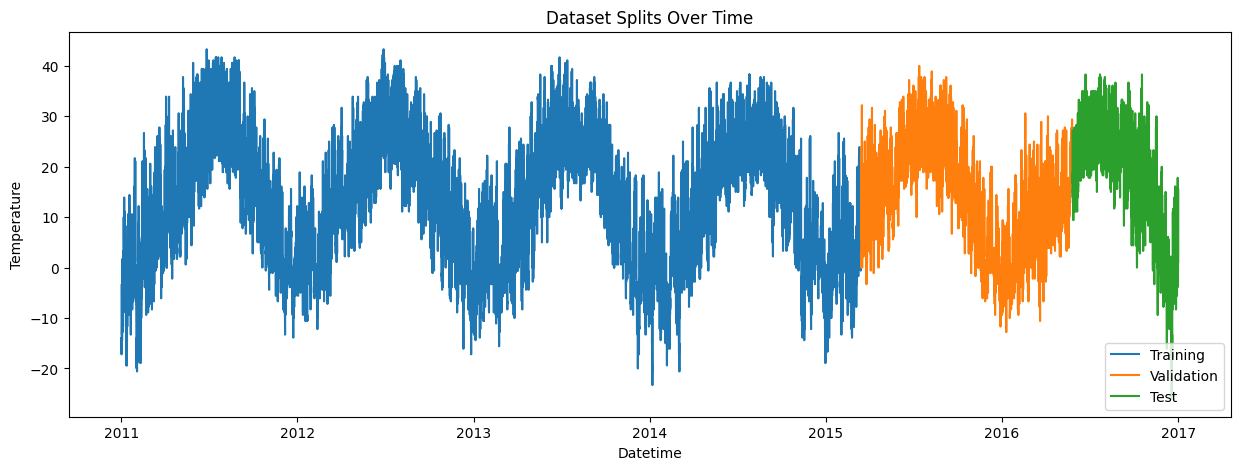

In [2]:
df = df.sort_index()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f"Total samples: {n}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

num_features = df.shape[1]
print(f"Number of features: {num_features}")

# Plotting temperature over time to make sure everything worked
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['temperature'], label='Training')
plt.plot(val_df.index, val_df['temperature'], label='Validation')
plt.plot(test_df.index, test_df['temperature'], label='Test')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.title('Dataset Splits Over Time')
plt.show()

### Normalizing

In [3]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_15000/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


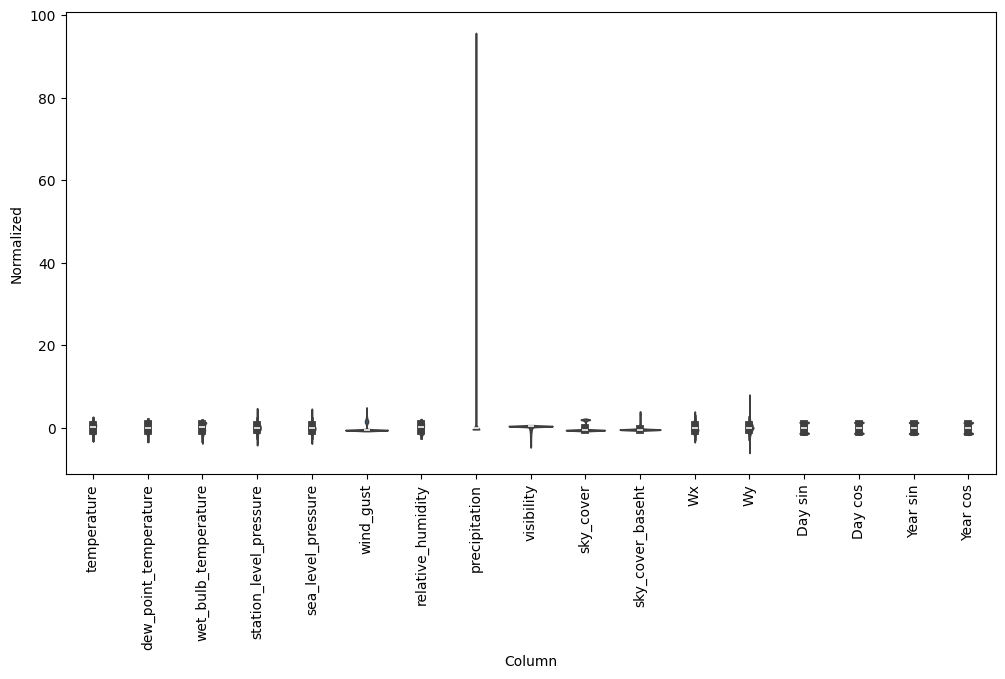

In [4]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 2-Data-windowing

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        """
        Initializes the WindowGenerator.

        Parameters:
        - input_width: Number of time steps in the input sequences.
        - label_width: Number of time steps in the label sequences.
        - shift: How many time steps to shift the input and labels.
        - train_df: Training DataFrame.
        - val_df: Validation DataFrame.
        - test_df: Test DataFrame.
        - label_columns: List of column names to be used as labels.
        """
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Store the column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        else:
            self.label_columns_indices = None
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Set window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Compute the total window size.
        self.total_window_size = input_width + shift

        # Define the slices for inputs and labels.
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [6]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [7]:
def plot(self, model=None, plot_col='temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time Steps')

WindowGenerator.plot = plot

In [8]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [10]:
# Create WindowGenerator instances
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24,
    label_columns=['temperature']
)
w1

w2 = WindowGenerator(
    input_width=6, label_width=1, shift=1,
    label_columns=['temperature']
)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

In [11]:
# window sizes for both w1 and w2
print(f"Total window size for w2: {w1.total_window_size}")
print(f"Total window size for w2: {w2.total_window_size}")

print(f"Length of train_df: {len(train_df)}")

Total window size for w2: 48
Total window size for w2: 7
Length of train_df: 36825


In [12]:
# Generate example windows with correct indexing
window_1 = np.array(train_df.iloc[:w2.total_window_size])
window_2 = np.array(train_df.iloc[100:100 + w2.total_window_size])
window_3 = np.array(train_df.iloc[200:200 + w2.total_window_size])

# Print shapes to verify
print(f"window_1 shape: {window_1.shape}")
print(f"window_2 shape: {window_2.shape}")
print(f"window_3 shape: {window_3.shape}")

# Stack the windows
example_window = tf.stack([window_1, window_2, window_3])

# Verify the shape of example_window
print(f"example_window shape: {example_window.shape}")

# Split the window into inputs and labels
example_inputs, example_labels = w2.split_window(example_window)

# Print shapes
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

window_1 shape: (7, 17)
window_2 shape: (7, 17)
window_3 shape: (7, 17)
example_window shape: (3, 7, 17)
All shapes are: (batch, time, features)
Window shape: (3, 7, 17)
Inputs shape: (3, 6, 17)
Labels shape: (3, 1, 1)


In [13]:
# Assign the example to w2 (if necessary)
w2._example = example_inputs, example_labels  # Use '_example' to cache the example

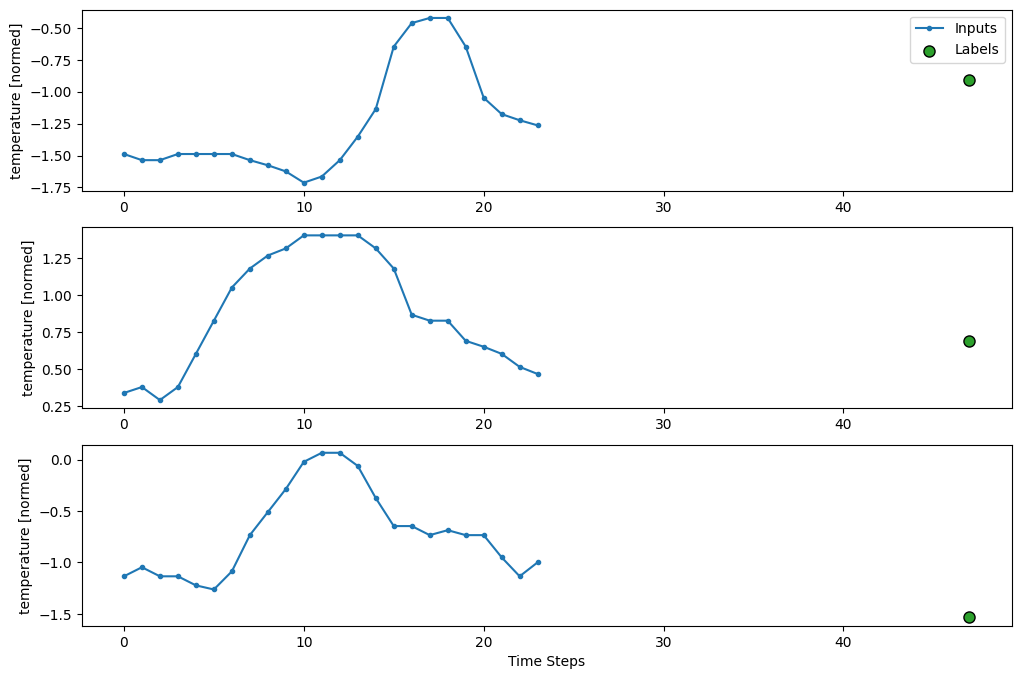

In [14]:
w1.plot(plot_col='temperature')

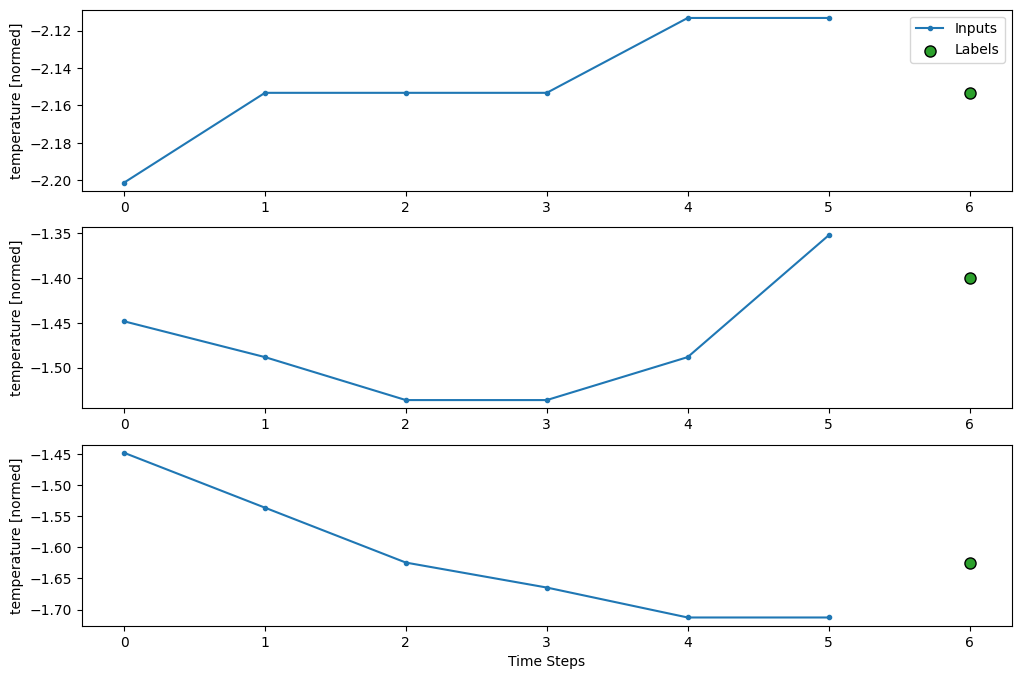

In [15]:
w2.plot(plot_col='temperature')

In [16]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 17), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 17)
Labels shape (batch, time, features): (32, 1, 1)


2024-12-02 18:50:12.407011: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 3-Single-Step-Models

## Single step models

In [18]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [19]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 17)
Labels shape (batch, time, features): (32, 1, 1)


2024-12-02 18:50:12.491854: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Baseline

In [20]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [21]:
baseline = Baseline(label_index=column_indices['temperature'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.0179 - mean_absolute_error: 0.0960


In [22]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

In [23]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Label shape:', wide_window.example[1].shape)
print('Prediction shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Label shape: (32, 24, 1)
Prediction shape: (32, 24, 1)


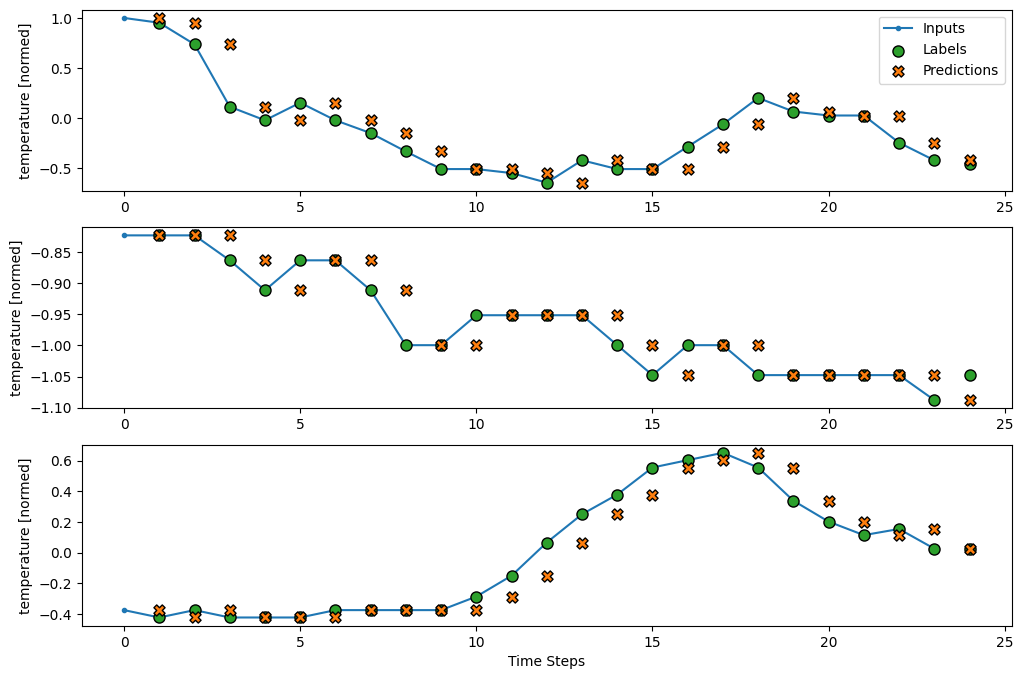

In [25]:
wide_window.plot(baseline)

### Linear Models

In [26]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [27]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 17)
Output shape: (32, 1, 1)


In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [29]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4886 - mean_absolute_error: 0.4819 - val_loss: 0.0153 - val_mean_absolute_error: 0.0929
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.0949 - val_loss: 0.0115 - val_mean_absolute_error: 0.0810
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0873 - val_loss: 0.0112 - val_mean_absolute_error: 0.0798
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0858 - val_loss: 0.0109 - val_mean_absolute_error: 0.0786
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0126 - mean_absolute_error: 0.0845 - val_loss: 0.0108 - val_mean_absolute_error: 0.0779
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0124 - mean_absolute_error: 0.0836 - val_loss: 0.0108 - val_mean_absolute_error: 0.0777
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0123 - mean_absolute_err

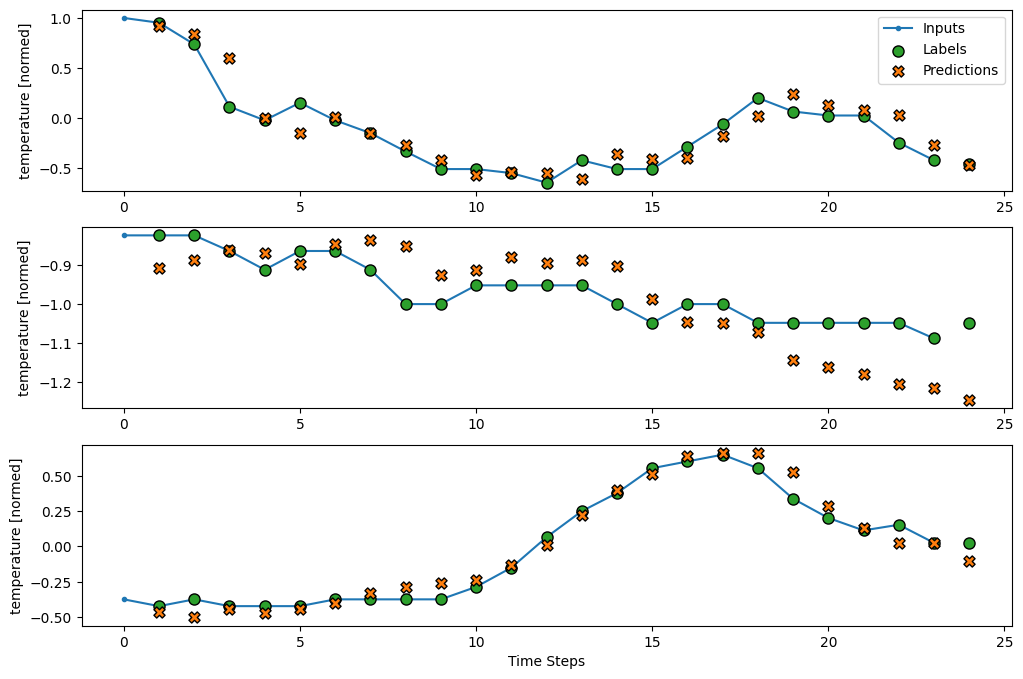

In [30]:
wide_window.plot(linear)

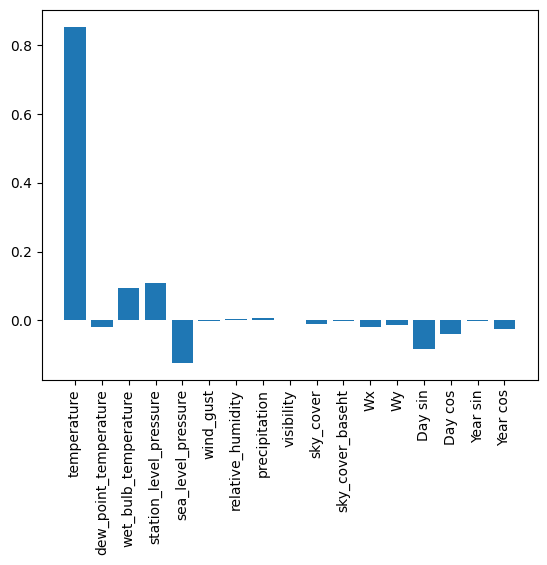

In [31]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense

In [32]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0511 - mean_absolute_error: 0.1414 - val_loss: 0.0098 - val_mean_absolute_error: 0.0747
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0773 - val_loss: 0.0097 - val_mean_absolute_error: 0.0701
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0727 - val_loss: 0.0080 - val_mean_absolute_error: 0.0665
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0074 - val_mean_absolute_error: 0.0634
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0685 - val_loss: 0.0074 - val_mean_absolute_error: 0.0631
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0675 - val_loss: 0.0073 - val_mean_absolute_error: 0.0631
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0083 - mean_absolute_err

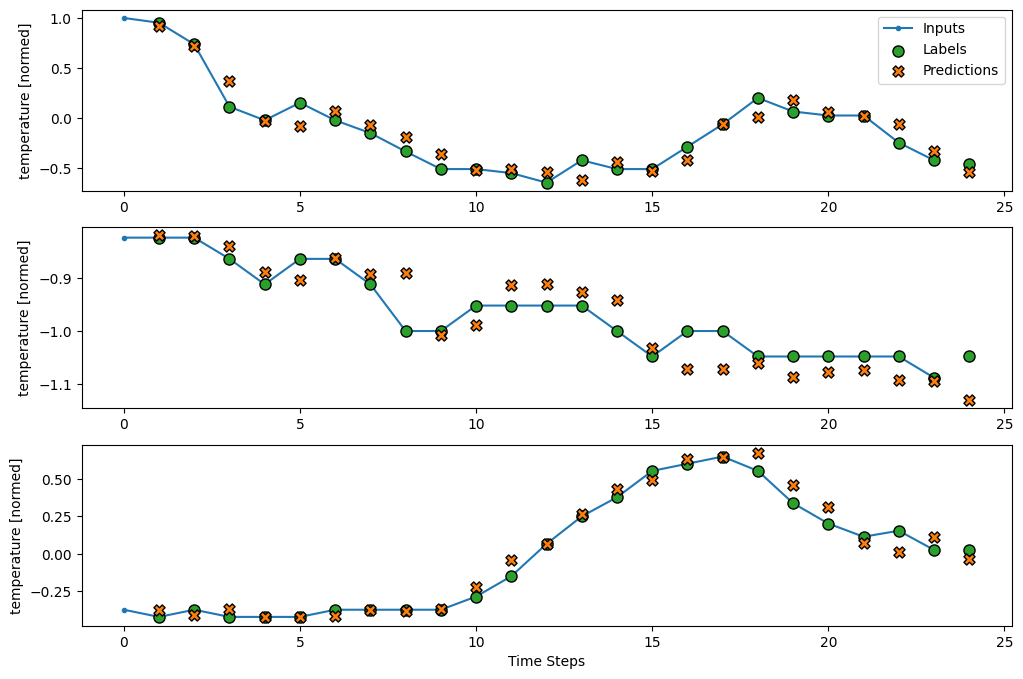

In [33]:
wide_window.plot(dense)

### Multi Dense

In [34]:
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['temperature'])

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

In [35]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [36]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 6, 17)
Output shape: (32, 1, 1)


In [37]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0076 - mean_absolute_error: 0.0643


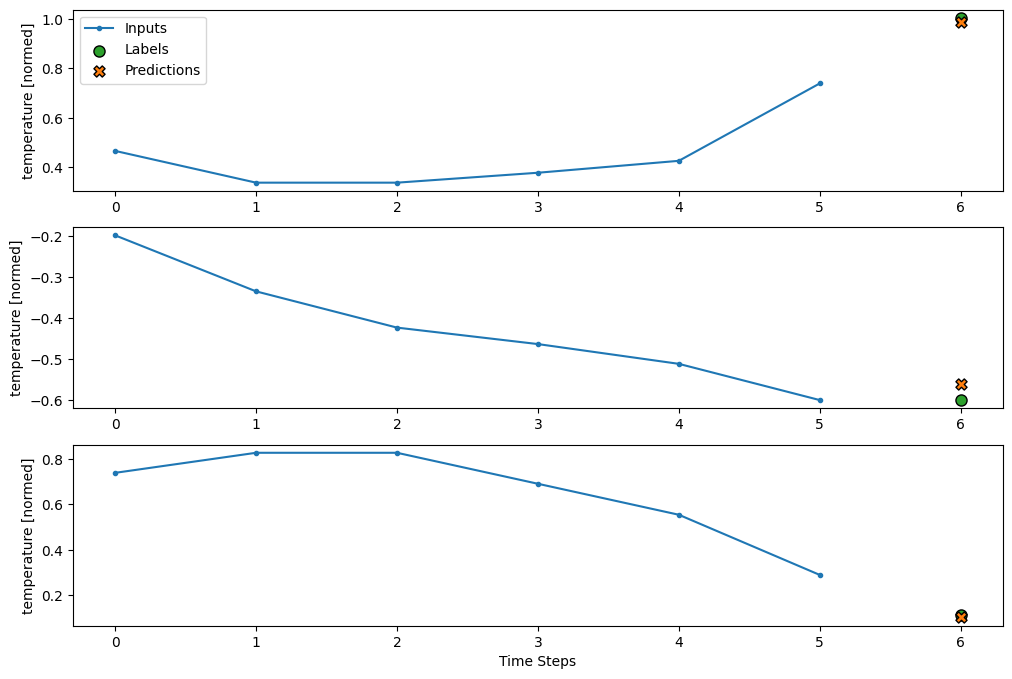

In [38]:
conv_window.plot(multi_step_dense)

In [39]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 17)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 102, but received input with shape (32, 408)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 17), dtype=float32)
  • training=None
  • mask=None


### CNN

In [40]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 6, 17)
Output shape: (32, 1, 1)


In [41]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0080 - mean_absolute_error: 0.0680


In [42]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 17)
Labels shape: (32, 24, 1)
Output shape: (32, 19, 1)


In [43]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['temperature'])

wide_conv_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['temperature']

In [44]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 29, 17)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


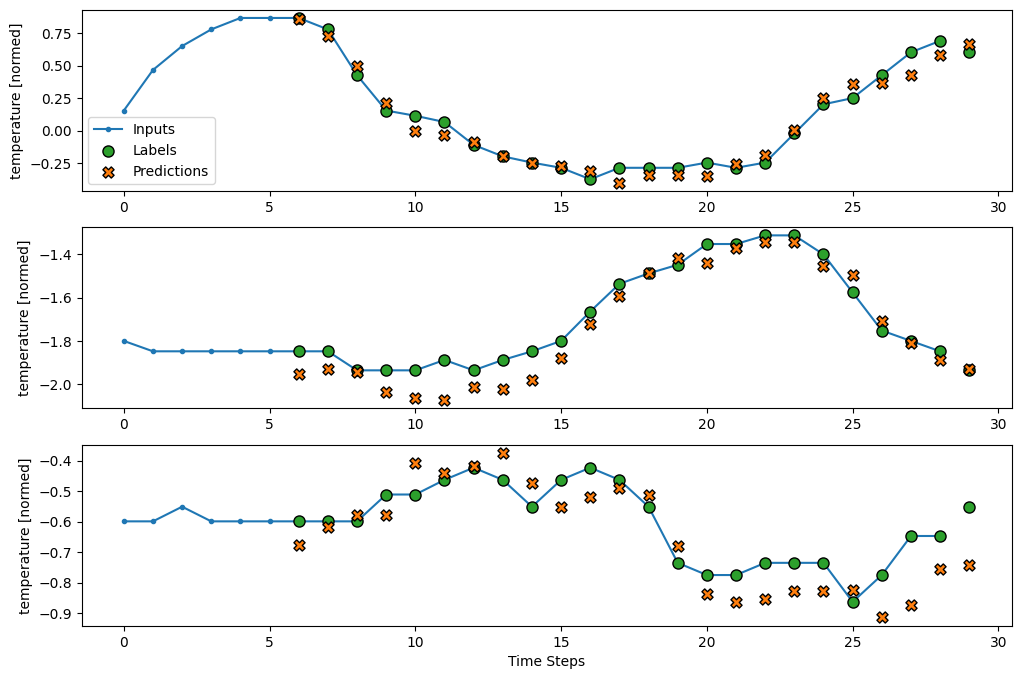

In [45]:
wide_conv_window.plot(conv_model)

### RNN

In [46]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


In [48]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0579


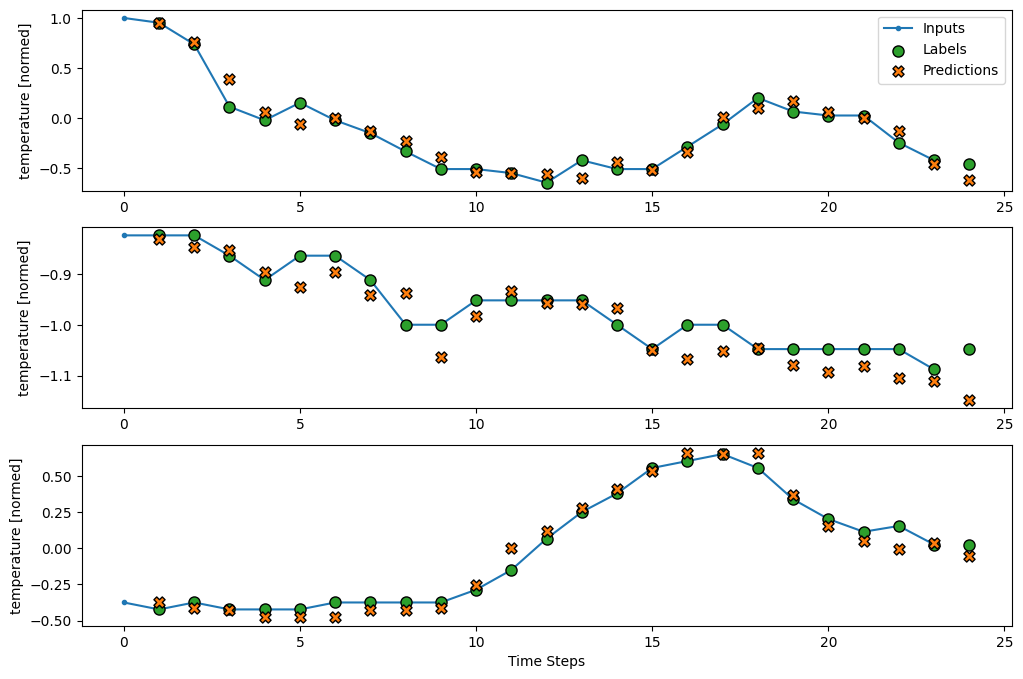

In [49]:
wide_window.plot(lstm_model)

### Performance

In [50]:
cm = lstm_model.metrics[1]
cm.metrics

val_performance

{'Baseline': {'loss': 0.017603332176804543,
  'mean_absolute_error': 0.09580662846565247},
 'Linear': {'loss': 0.010540090501308441,
  'mean_absolute_error': 0.07669530063867569},
 'Dense': {'loss': 0.007524470798671246,
  'mean_absolute_error': 0.06048158183693886},
 'Multi step dense': {'loss': 0.007472539786249399,
  'mean_absolute_error': 0.06396014243364334},
 'Conv': {'loss': 0.00836057960987091,
  'mean_absolute_error': 0.06933299452066422},
 'LSTM': {'loss': 0.006217404268682003,
  'mean_absolute_error': 0.05772615969181061}}

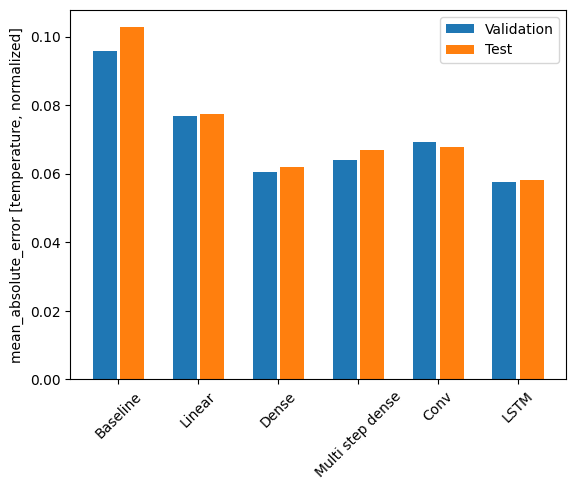

In [51]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [temperature, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Multi Output Models

In [52]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 17)
Labels shape (batch, time, features): (32, 24, 17)


### Baseline

In [53]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3307 - mean_absolute_error: 0.1688


### Dense

In [54]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.2879 - mean_absolute_error: 0.1773


### RNN

In [55]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2396 - mean_absolute_error: 0.1777

CPU times: user 58.2 s, sys: 20.7 s, total: 1min 18s
Wall time: 31.6 s


### Residual Connections

In [56]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [57]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2627 - mean_absolute_error: 0.1711

CPU times: user 1min 6s, sys: 24.4 s, total: 1min 30s
Wall time: 35.6 s


### Single Step Multi Output Results

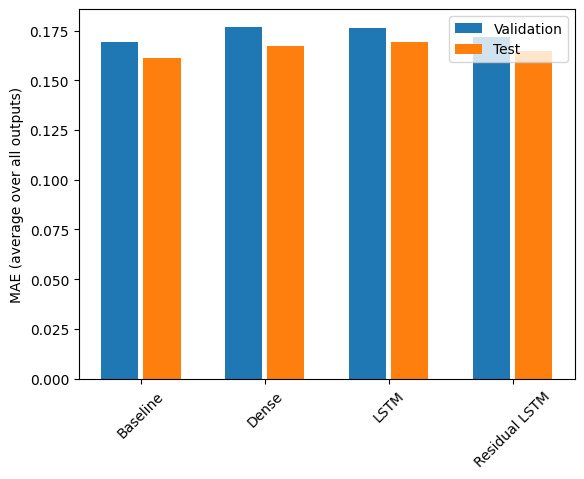

In [58]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# 4-Multi-Step-Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

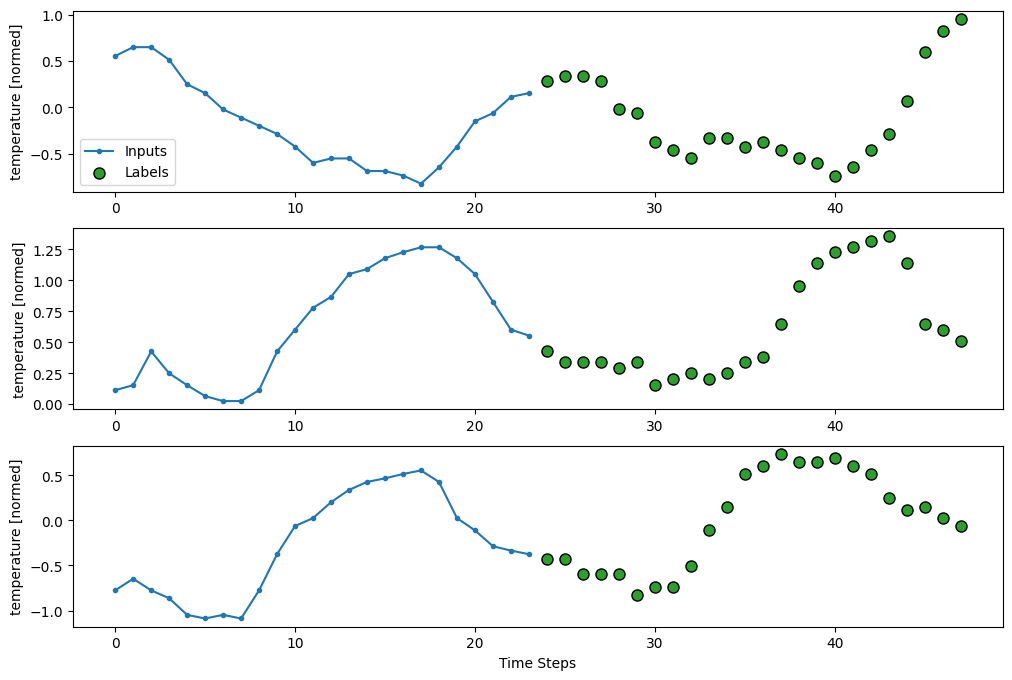

In [59]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0827 - mean_absolute_error: 0.5432


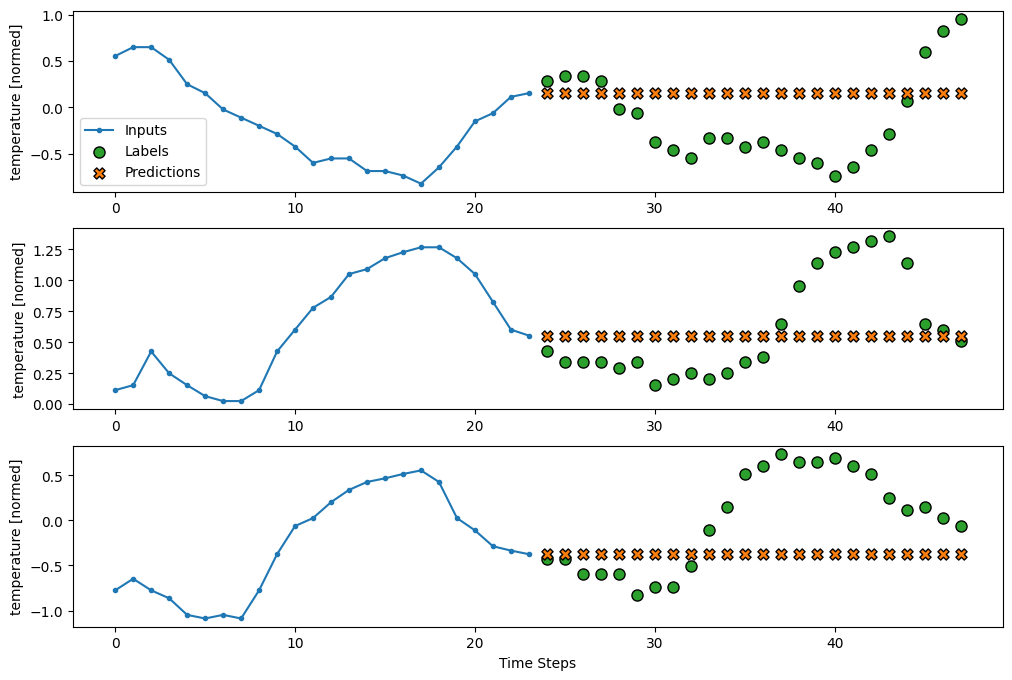

In [60]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0304 - mean_absolute_error: 0.4578


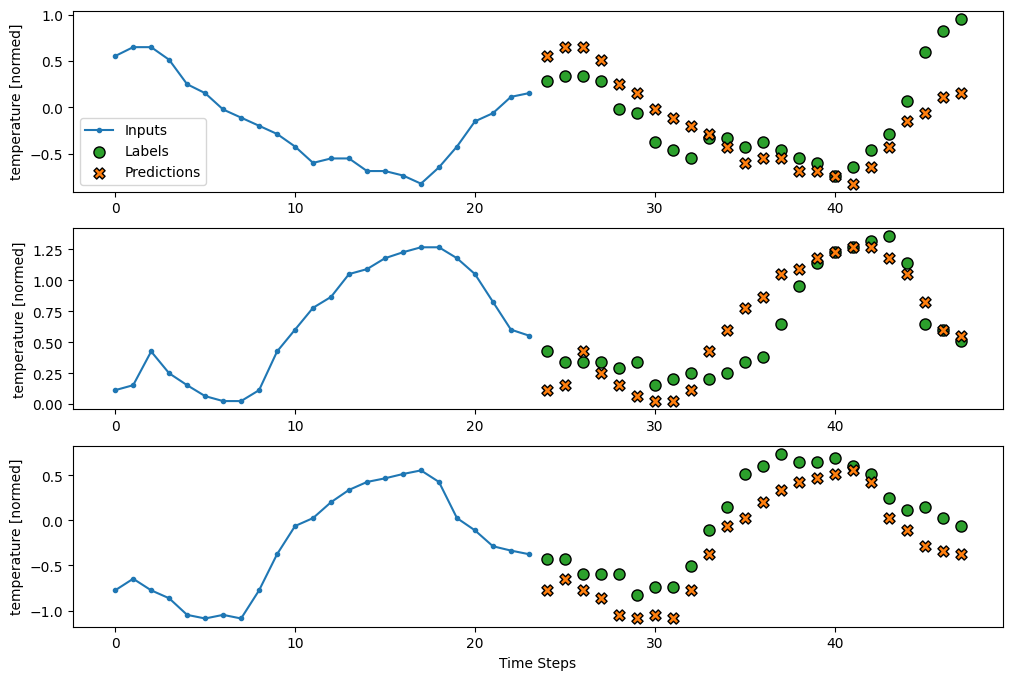

In [61]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

### Single Shot Models

#### Linear

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.5045 - mean_absolute_error: 0.3480


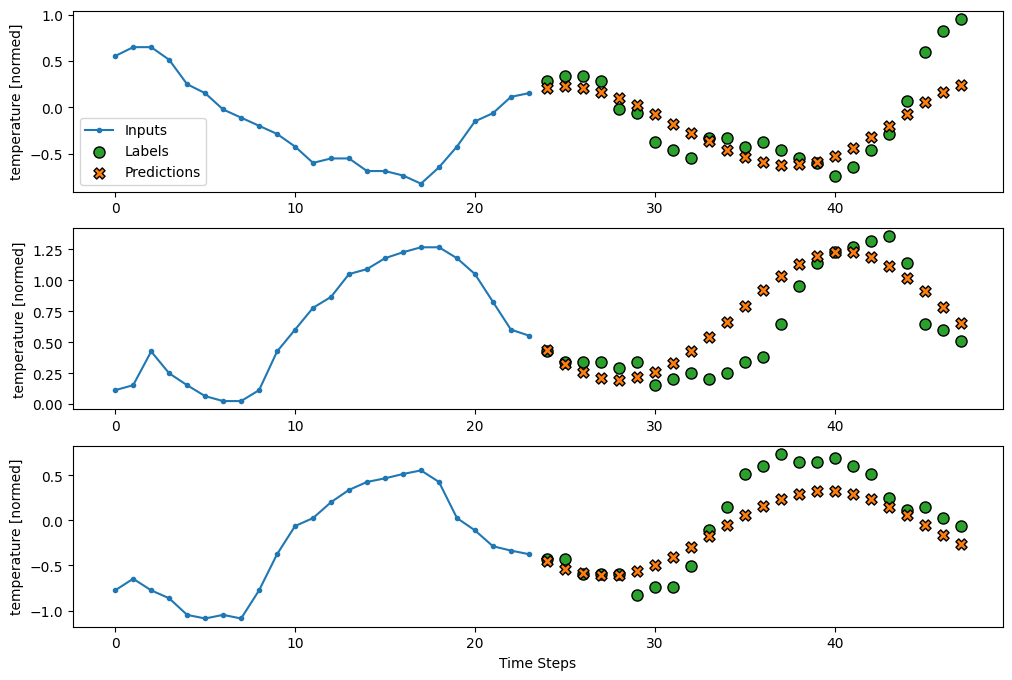

In [62]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

#### Dense

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4567 - mean_absolute_error: 0.3414


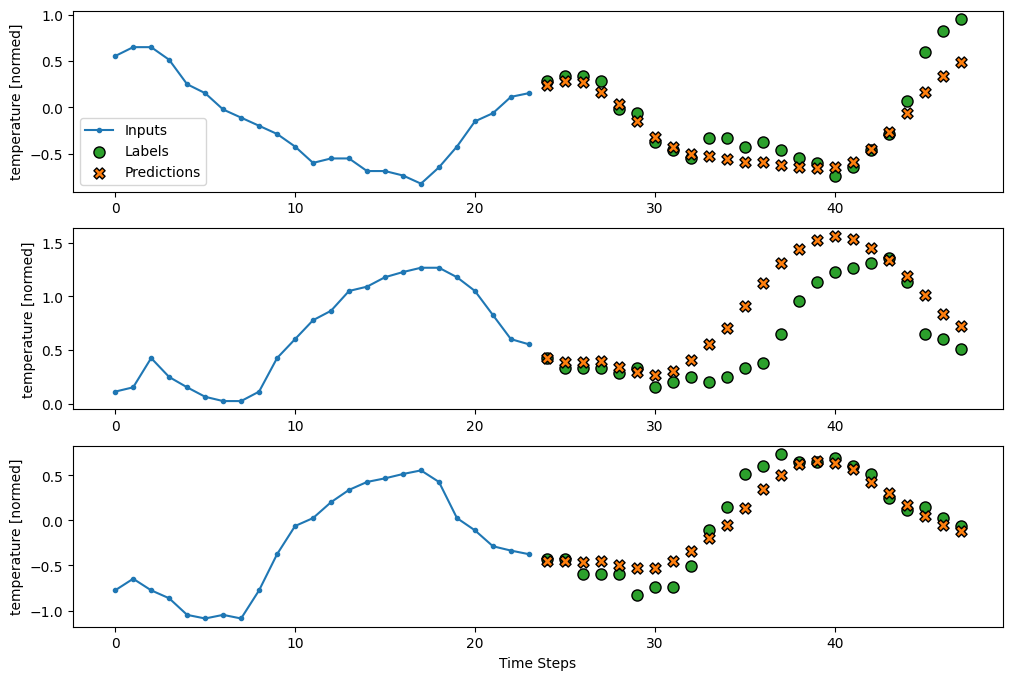

In [63]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

#### CNN

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4683 - mean_absolute_error: 0.3437


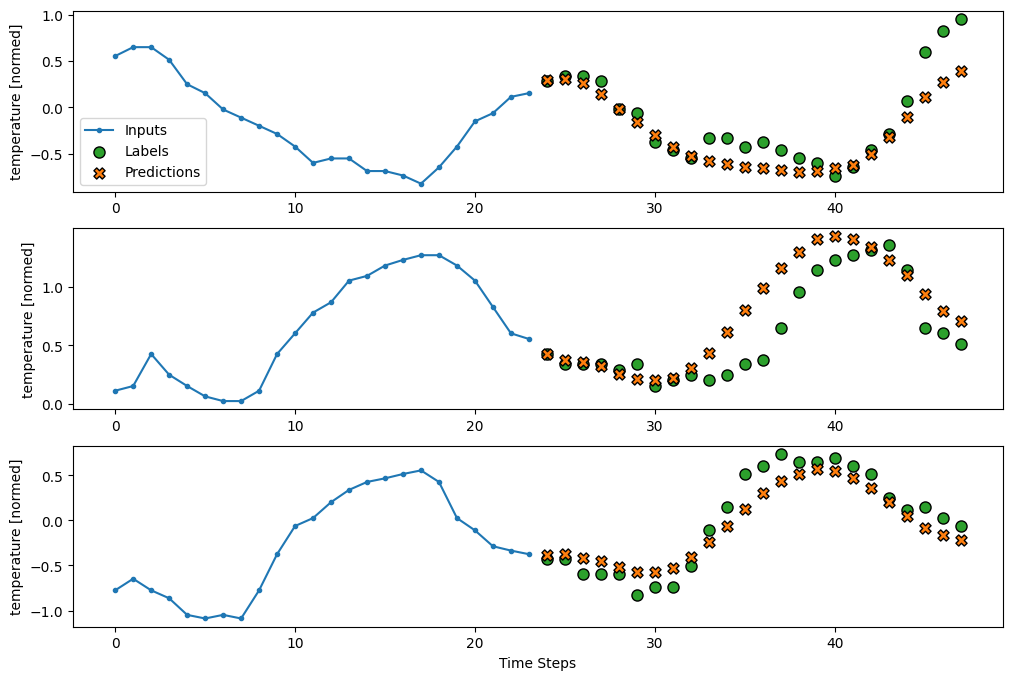

In [64]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

#### RNN

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4756 - mean_absolute_error: 0.3536


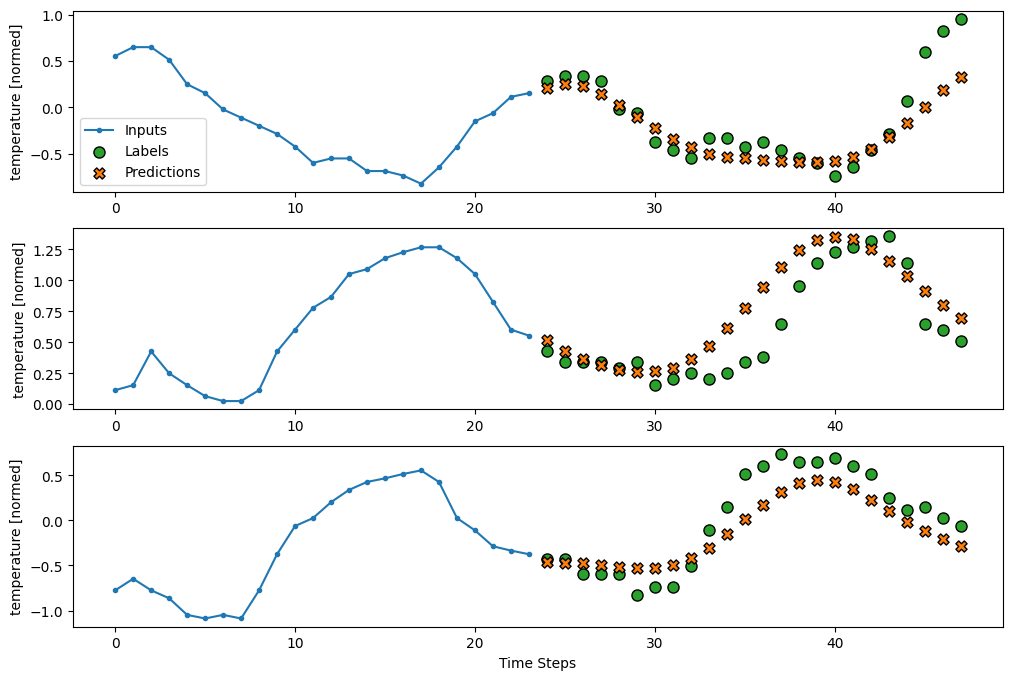

In [65]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Autoregressive

#### RNN

In [66]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [67]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [68]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [69]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 17])

In [70]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [71]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 17)


328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4926 - mean_absolute_error: 0.3691


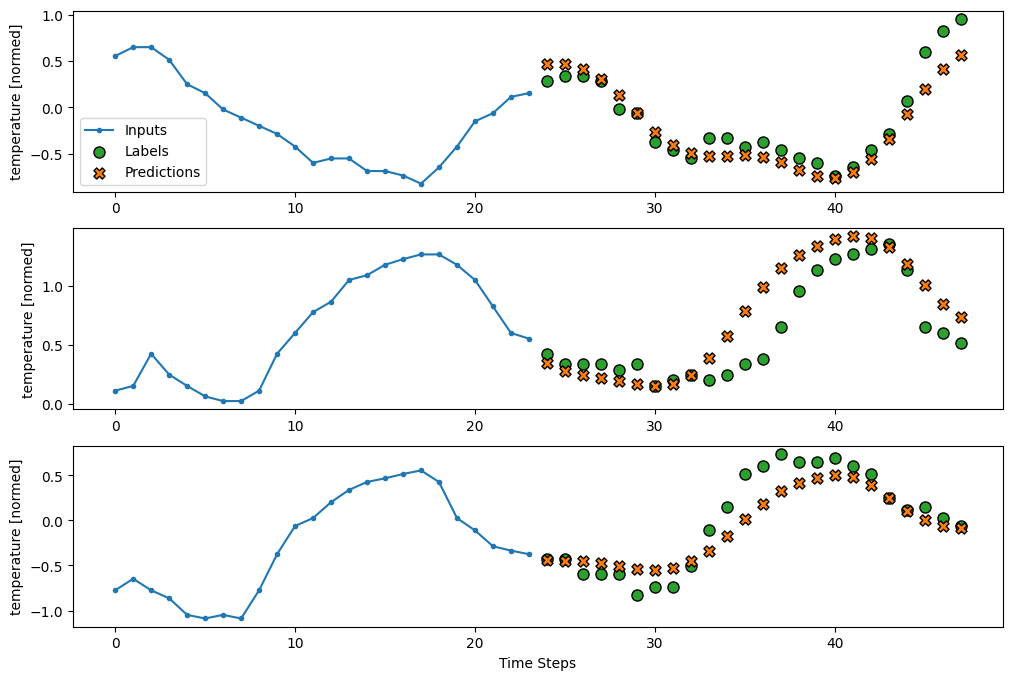

In [72]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Performance

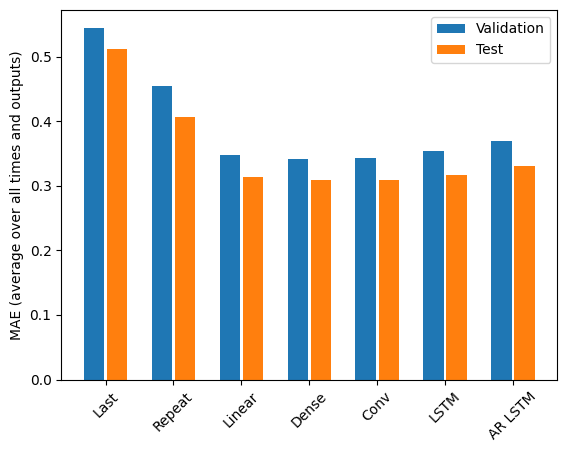

In [73]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()